In [1]:
from IPython.display import Image, display
import numpy as np
import os
from os.path import join
from PIL import ImageFile
import pandas as pd
from matplotlib import cm
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.isotonic import IsotonicRegression
import re

ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.style.use('fivethirtyeight')
%matplotlib inline

In [37]:
train_img_dir_n = "C:\\Github\\Cassava-Disease-Classification-Using-Line-BOT\\Dataset\\natural_images\\cassava"
train_img_paths_n = [join(train_img_dir_n,filename) for filename in os.listdir(train_img_dir_n)]

In [38]:
train_img_paths, test_img_paths_cassava = train_test_split(train_img_paths_n, test_size=0.25, random_state=42)
train_img_paths, val_img_paths_cassava = train_test_split(train_img_paths, test_size=0.25, random_state=42)

In [39]:
natural_images_path = "C:\\Github\\Cassava-Disease-Classification-Using-Line-BOT\\Dataset\\natural_images\\"
test_img_paths_no_cassava = []
for d in [d for d in os.listdir("C:\\Github\\Cassava-Disease-Classification-Using-Line-BOT\\Dataset\\natural_images") if d!= "cassava"]:
    test_img_dir_na = natural_images_path+d
    test_img_paths_no_cassava.append([join(test_img_dir_na,filename) for filename in os.listdir(test_img_dir_na)])
    
test_img_paths_no_cassava_flat = [item for sublist in test_img_paths_no_cassava for item in sublist]
test_img_paths_no_cassava, val_img_paths_no_cassava = train_test_split(test_img_paths_no_cassava_flat, test_size = 0.25, random_state = 42)

In [57]:
def natural_img_dir(image_path):
    path_regex = r'natural_images\\(\w*)'
    if 'natural_images' in image_path:
        print(re.findall(path_regex,image_path,re.MULTILINE))
        return re.findall(path_regex,image_path,re.MULTILINE)[0].strip()
    else:
        return 'cassava'

In [58]:
all_test_paths = test_img_paths_cassava+test_img_paths_no_cassava
test_path_df = pd.DataFrame({'path': all_test_paths,
                             'is_cassava': [1 if path in test_img_paths_cassava else 0 for path in all_test_paths]})
test_path_df = shuffle(test_path_df,random_state = 0).reset_index(drop = True)
test_path_df['image_type'] = test_path_df['path'].apply(lambda x: natural_img_dir(x))
all_test_paths = test_path_df['path'].tolist()

['car']
['person']
['airplane']
['person']
['car']
['flower']
['cat']
['dog']
['airplane']
['motorbike']
['person']
['cat']
['cassava']
['fruit']
['person']
['flower']
['airplane']
['cat']
['car']
['flower']
['car']
['motorbike']
['fruit']
['cassava']
['car']
['fruit']
['fruit']
['person']
['fruit']
['cassava']
['fruit']
['dog']
['fruit']
['motorbike']
['fruit']
['person']
['car']
['airplane']
['dog']
['airplane']
['person']
['dog']
['fruit']
['motorbike']
['car']
['cat']
['car']
['cat']
['car']
['fruit']
['car']
['airplane']
['dog']
['fruit']
['airplane']
['fruit']
['flower']
['person']
['cat']
['car']
['person']
['flower']
['dog']
['person']
['person']
['fruit']
['person']
['cat']
['fruit']
['flower']
['dog']
['cat']
['flower']
['flower']
['cat']
['dog']
['dog']
['motorbike']
['motorbike']
['cassava']
['car']
['person']
['car']
['fruit']
['flower']
['airplane']
['car']
['person']
['car']
['car']
['motorbike']
['fruit']
['flower']
['fruit']
['flower']
['dog']
['cat']
['car']
['car']
[

In [59]:
test_path_df

,path,is_cassava,image_type
0,C:\Github\Cassava-Disease-Classification-Using...,0,car
1,C:\Github\Cassava-Disease-Classification-Using...,0,person
2,C:\Github\Cassava-Disease-Classification-Using...,0,airplane
3,C:\Github\Cassava-Disease-Classification-Using...,0,person
4,C:\Github\Cassava-Disease-Classification-Using...,0,car
...,...,...,...
5471,C:\Github\Cassava-Disease-Classification-Using...,0,fruit
5472,C:\Github\Cassava-Disease-Classification-Using...,0,car
5473,C:\Github\Cassava-Disease-Classification-Using...,0,flower
5474,C:\Github\Cassava-Disease-Classification-Using...,0,person


In [60]:
all_val_paths = val_img_paths_cassava+val_img_paths_no_cassava
val_path_df = pd.DataFrame({
    'path': all_val_paths,
    'is_cassava': [1 if path in val_img_paths_cassava else 0 for path in all_val_paths]
})
val_path_df = shuffle(val_path_df,random_state = 0).reset_index(drop = True)
val_path_df['image_type'] = val_path_df['path'].apply(lambda x: natural_img_dir(x))
all_val_paths = val_path_df['path'].tolist()

['cassava']
['motorbike']
['flower']
['cassava']
['fruit']
['cassava']
['flower']
['fruit']
['car']
['car']
['person']
['dog']
['cassava']
['cat']
['car']
['fruit']
['airplane']
['car']
['person']
['flower']
['car']
['car']
['motorbike']
['person']
['cassava']
['car']
['airplane']
['car']
['cat']
['motorbike']
['person']
['motorbike']
['motorbike']
['dog']
['cassava']
['fruit']
['dog']
['car']
['person']
['flower']
['cassava']
['person']
['cat']
['cassava']
['cat']
['car']
['flower']
['fruit']
['person']
['cat']
['fruit']
['person']
['airplane']
['cat']
['person']
['cat']
['fruit']
['person']
['person']
['flower']
['cassava']
['person']
['cassava']
['fruit']
['flower']
['flower']
['airplane']
['cat']
['airplane']
['airplane']
['airplane']
['flower']
['motorbike']
['cassava']
['cat']
['person']
['cat']
['motorbike']
['cat']
['fruit']
['cassava']
['dog']
['person']
['flower']
['car']
['person']
['car']
['car']
['motorbike']
['dog']
['person']
['dog']
['cassava']
['car']
['cassava']
['flo

In [61]:
val_path_df

,path,is_cassava,image_type
0,C:\Github\Cassava-Disease-Classification-Using...,1,cassava
1,C:\Github\Cassava-Disease-Classification-Using...,0,motorbike
2,C:\Github\Cassava-Disease-Classification-Using...,0,flower
3,C:\Github\Cassava-Disease-Classification-Using...,1,cassava
4,C:\Github\Cassava-Disease-Classification-Using...,0,fruit
...,...,...,...
1946,C:\Github\Cassava-Disease-Classification-Using...,0,dog
1947,C:\Github\Cassava-Disease-Classification-Using...,0,airplane
1948,C:\Github\Cassava-Disease-Classification-Using...,0,car
1949,C:\Github\Cassava-Disease-Classification-Using...,0,dog


In [8]:
image_size = 224

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = img_array
    output = preprocess_input(img_array)
    return(output)

X_train = read_and_prep_images(train_img_paths)
X_test = read_and_prep_images(all_test_paths)
X_val = read_and_prep_images(all_val_paths)

In [9]:
X_train

(677, 224, 224, 3)

In [11]:
# get features from resnet50 

resnet_weights_path = 'C:\Github\Cassava-Disease-Classification-Using-Line-BOT\resNet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# X : images numpy array
resnet_model = ResNet50(input_shape=(image_size, image_size, 3), weights="imagenet", include_top=False, pooling='avg')  # Since top layer is the fc layer used for predictions

X_train = resnet_model.predict(X_train)
X_test = resnet_model.predict(X_test)
X_val = resnet_model.predict(X_val)

61/61 [==============================] - 240s 4s/step


In [12]:
# Apply standard scaler to output from resnet50
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=512, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

Explained variance percentage = 0.98


In [13]:
# Train classifier and obtain predictions for OC-SVM
oc_svm_clf = svm.OneClassSVM(gamma=0.001, kernel='rbf', nu=0.08)  # Obtained using grid search
if_clf = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)  # Obtained using grid search

oc_svm_clf.fit(X_train)
if_clf.fit(X_train)

oc_svm_preds = oc_svm_clf.predict(X_test)
if_preds = if_clf.predict(X_test)

In [84]:
X_train.shape

(677, 512)

In [62]:
svm_if_results=pd.DataFrame({
  'path': all_test_paths,
  'oc_svm_preds': [0 if x == -1 else 1 for x in oc_svm_preds],
  'if_preds': [0 if x == -1 else 1 for x in if_preds]
})


svm_if_results=svm_if_results.merge(test_path_df)
svm_if_results.head()

,path,oc_svm_preds,if_preds,is_cassava,image_type
0,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,car
1,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,person
2,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,airplane
3,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,person
4,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,car


In [68]:
svm_if_results

,path,oc_svm_preds,if_preds,is_cassava,image_type
0,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,car
1,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,person
2,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,airplane
3,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,person
4,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,car
...,...,...,...,...,...
5471,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,fruit
5472,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,car
5473,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,flower
5474,C:\Github\Cassava-Disease-Classification-Using...,1,1,0,person


roc auc score: if_preds
0.9338842710751926
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5174
           1       0.94      0.87      0.91       302

    accuracy                           0.99      5476
   macro avg       0.97      0.93      0.95      5476
weighted avg       0.99      0.99      0.99      5476



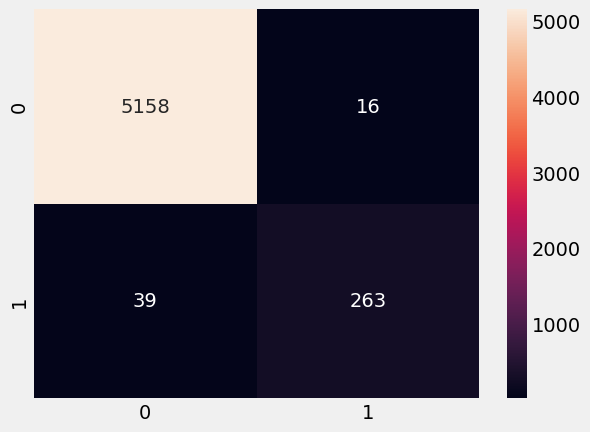

In [16]:
print('roc auc score: if_preds')
if_preds=svm_if_results['if_preds']
actual=svm_if_results['is_cassava']
print(roc_auc_score(actual, if_preds))
print(classification_report(actual, if_preds))
sns.heatmap(confusion_matrix(actual, if_preds),annot=True,fmt='2.0f')
plt.show()

roc auc score: oc_svm_preds
0.9116718334412767
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5174
           1       0.98      0.82      0.89       302

    accuracy                           0.99      5476
   macro avg       0.98      0.91      0.94      5476
weighted avg       0.99      0.99      0.99      5476



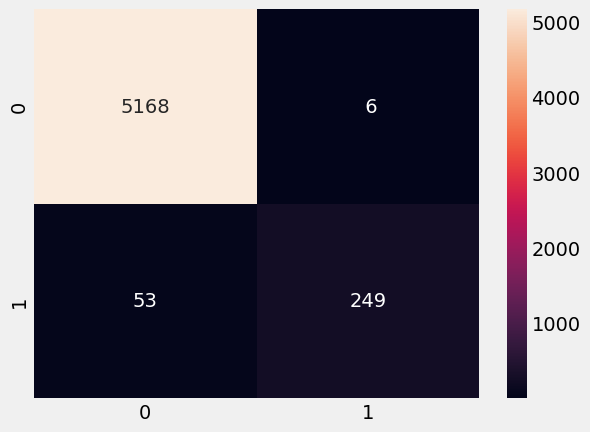

In [17]:
print('roc auc score: oc_svm_preds')
oc_svm_preds=svm_if_results['oc_svm_preds']
actual=svm_if_results['is_cassava']
print(roc_auc_score(actual, oc_svm_preds))
print(classification_report(actual, oc_svm_preds))
sns.heatmap(confusion_matrix(actual, oc_svm_preds),annot=True,fmt='2.0f')
plt.show()

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


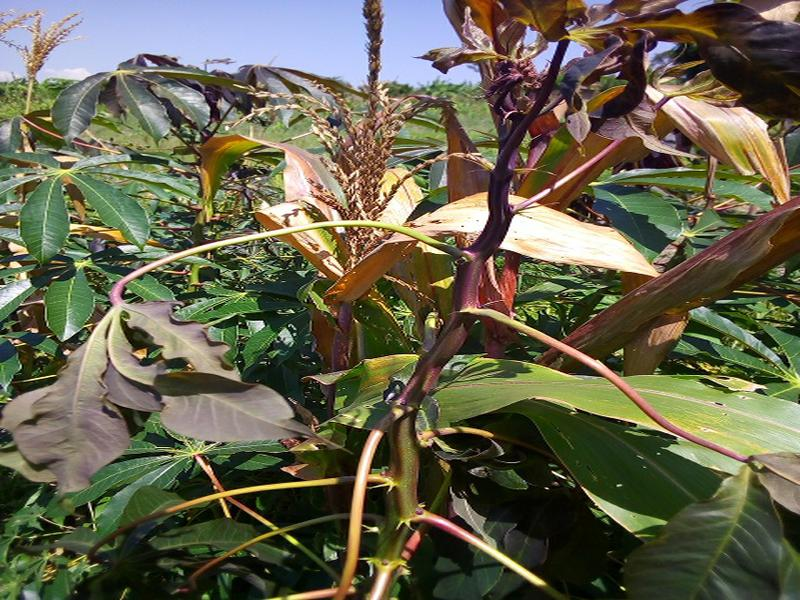

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


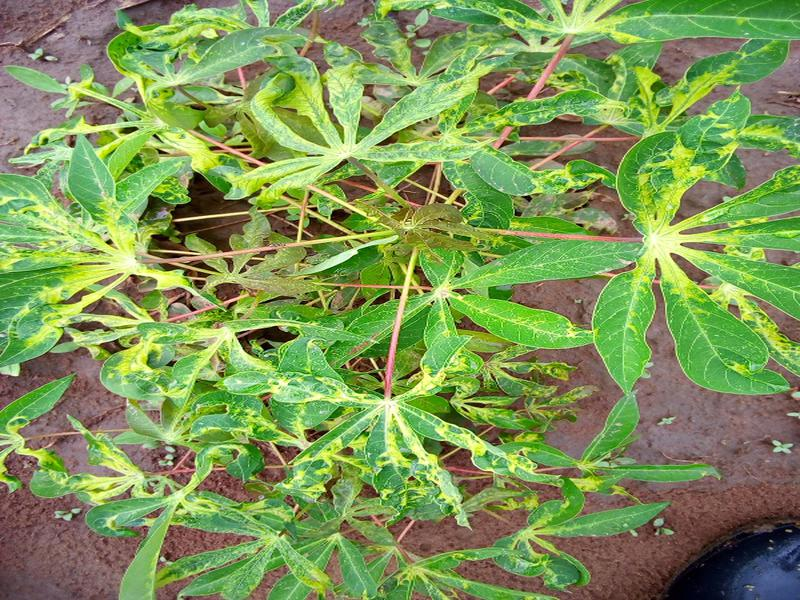

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


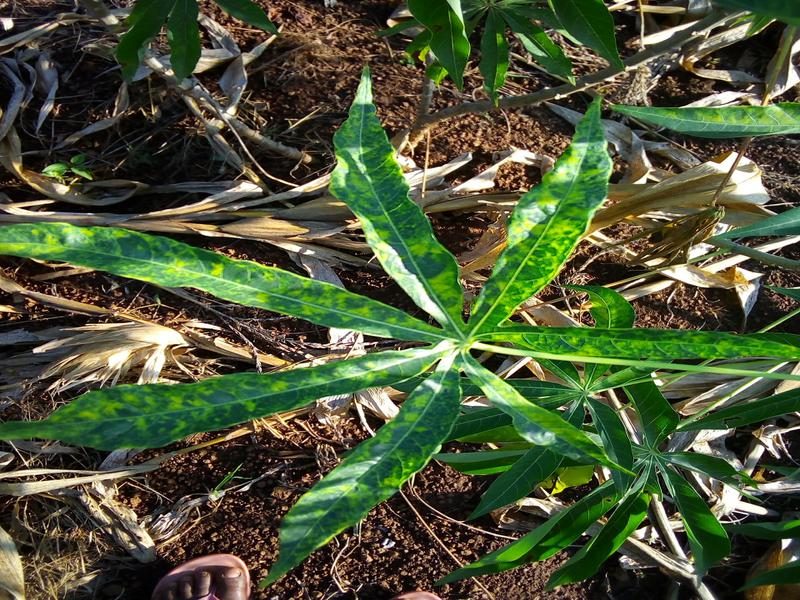

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


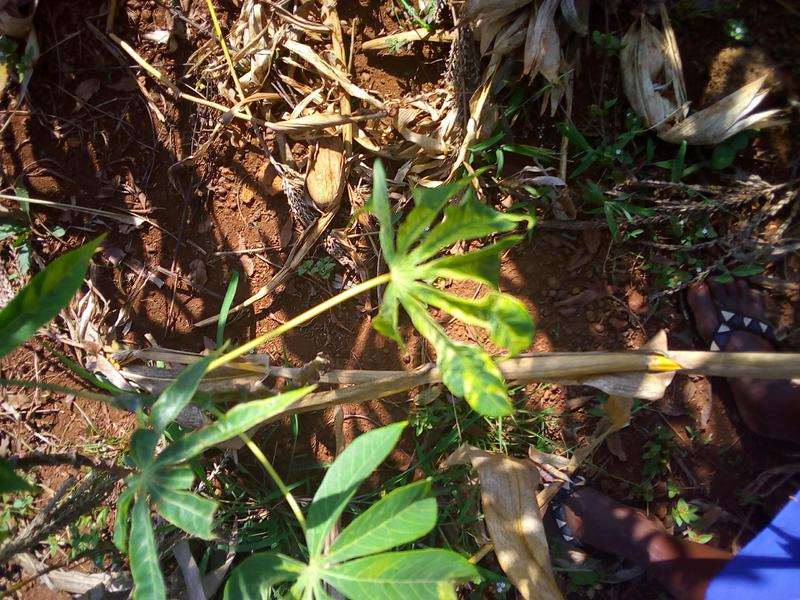

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


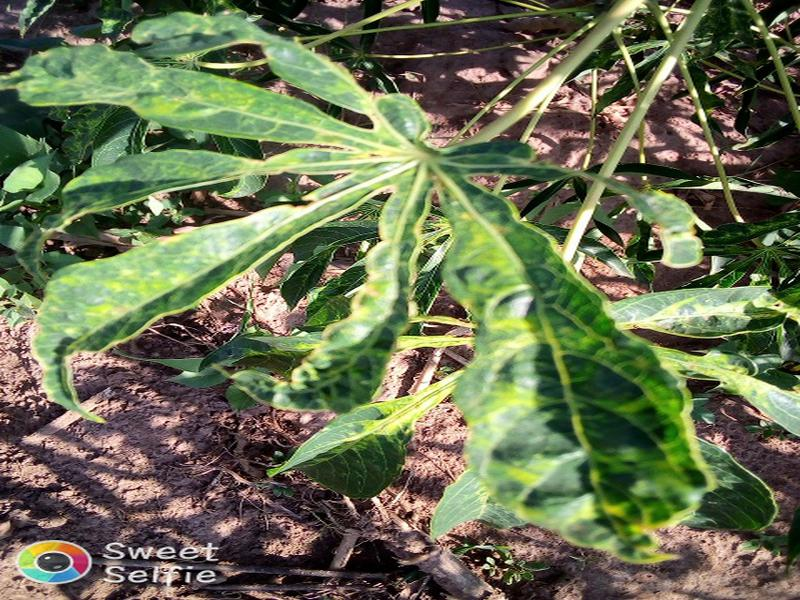

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


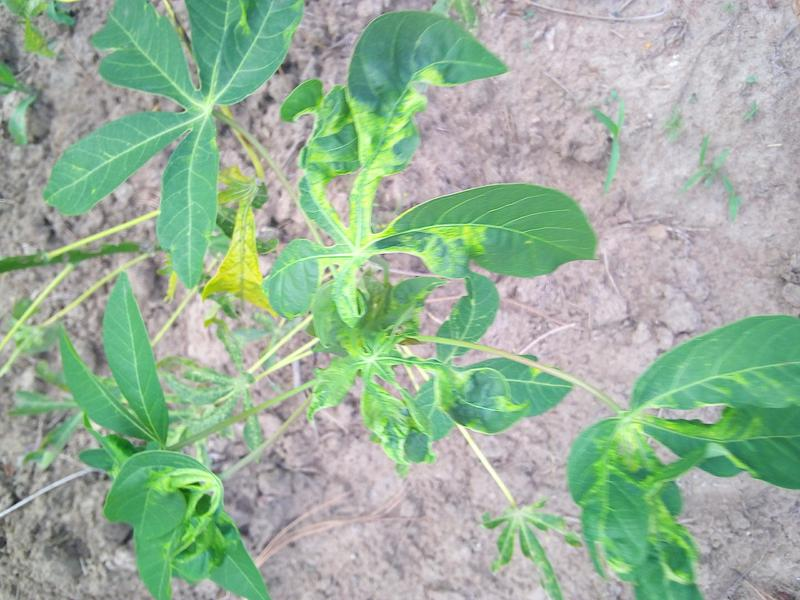

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


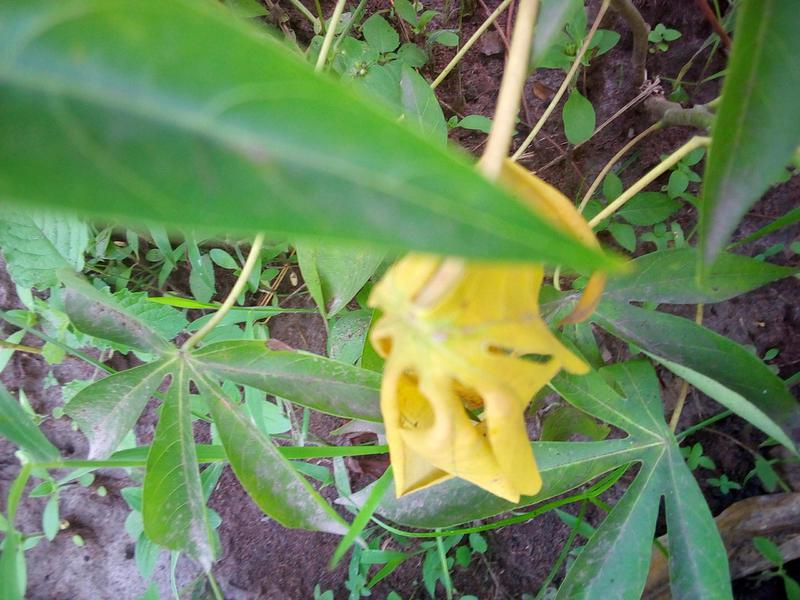

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


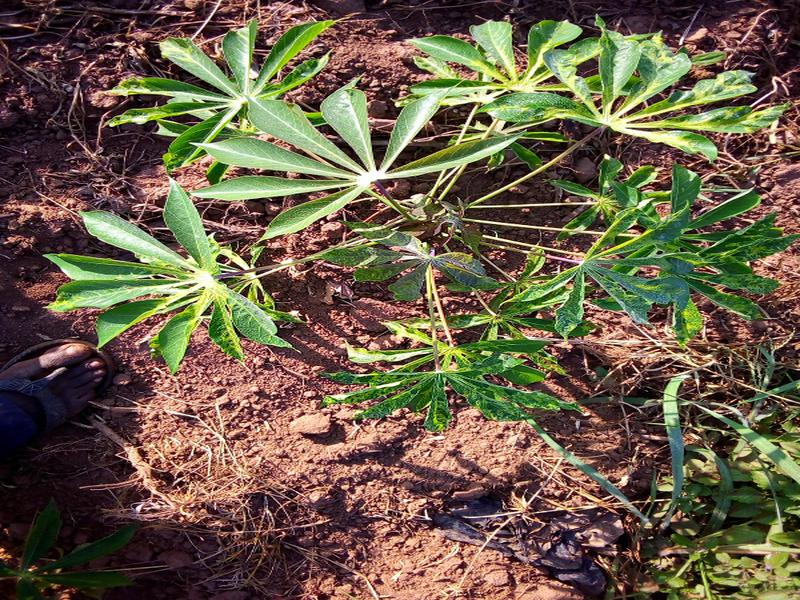

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


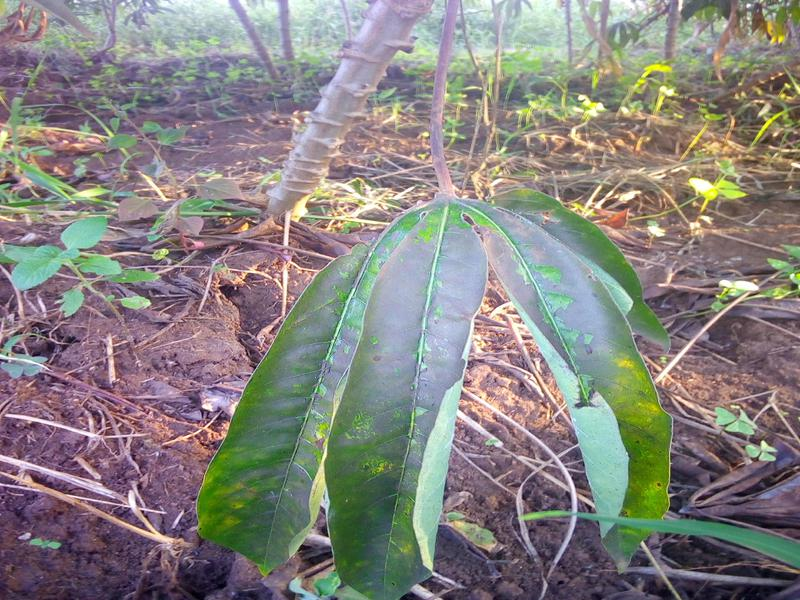

FALSE POSITIVE
oc_svm_preds: 1 | actual: 0


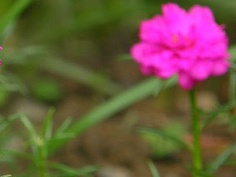

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


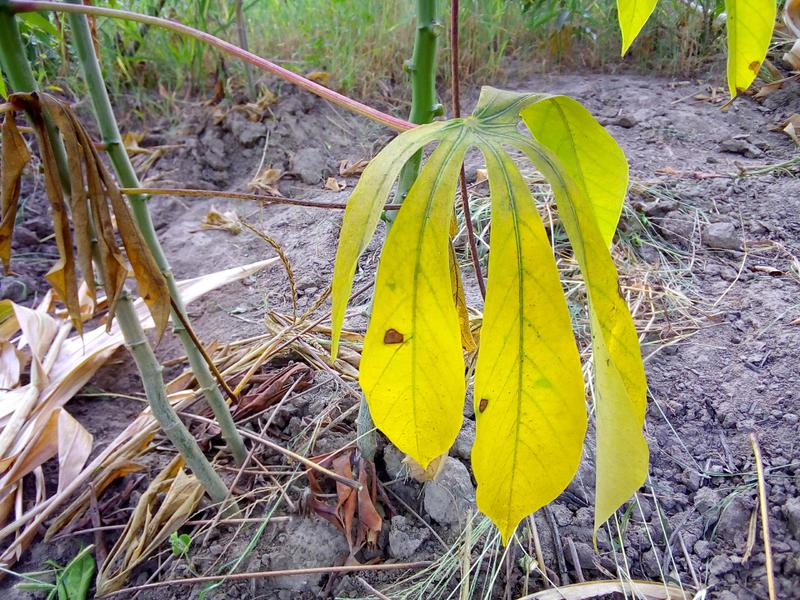

FALSE POSITIVE
oc_svm_preds: 1 | actual: 0


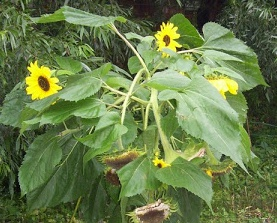

FALSE POSITIVE
oc_svm_preds: 1 | actual: 0


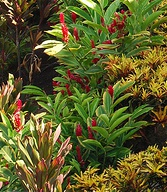

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


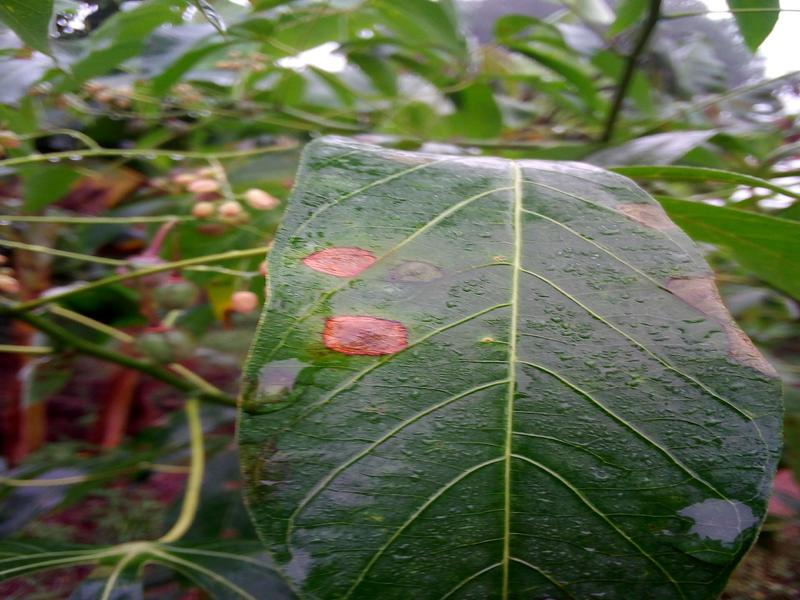

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


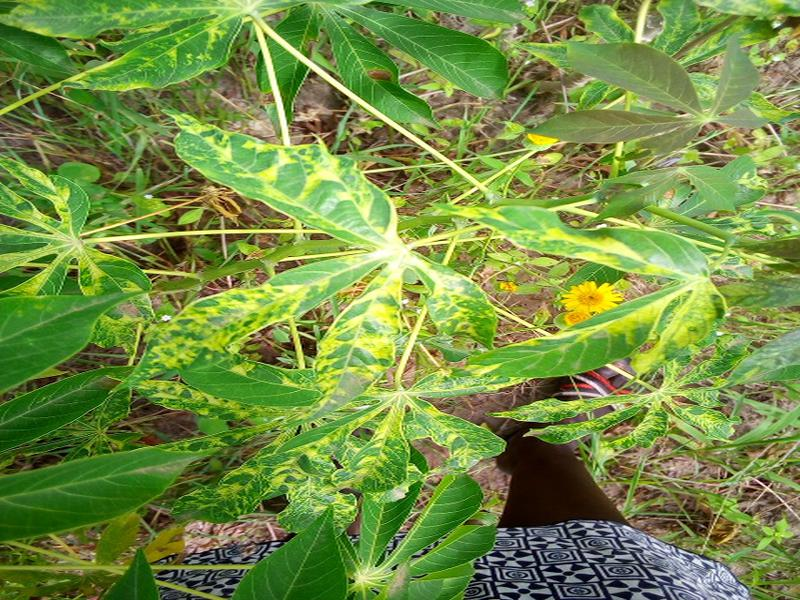

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


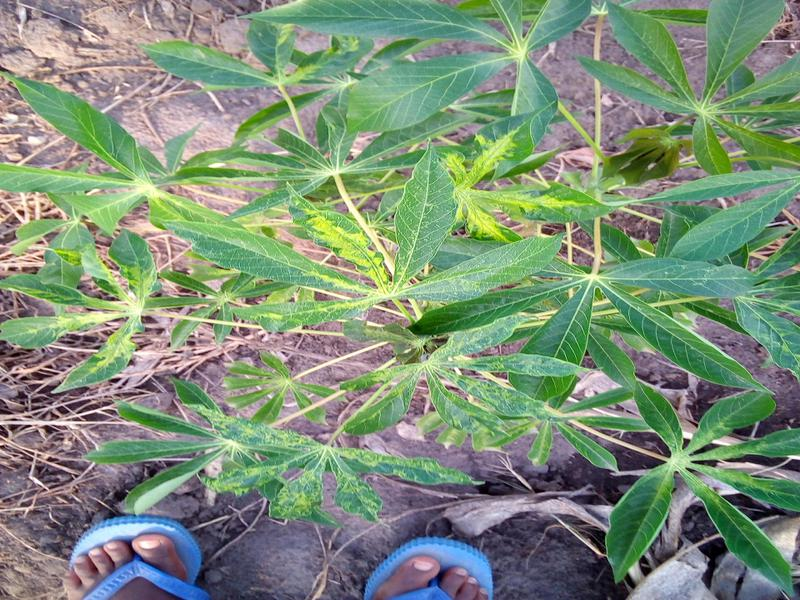

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


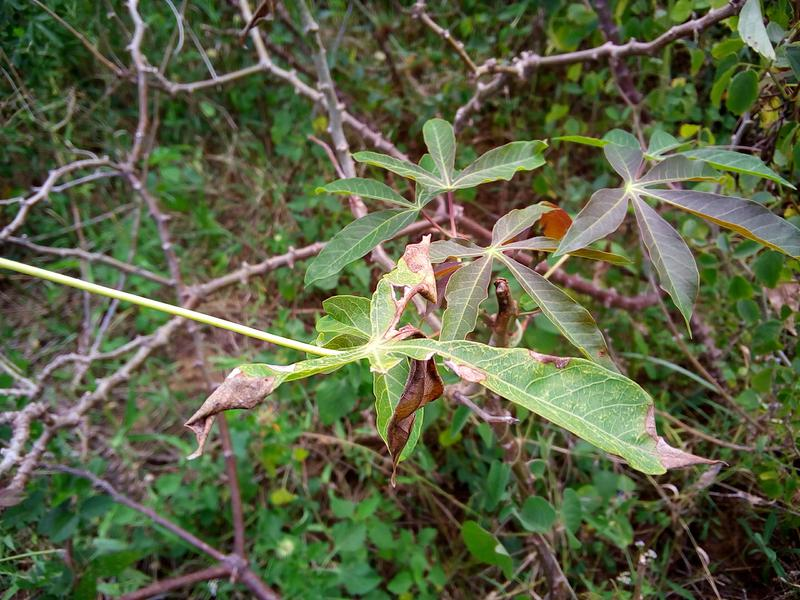

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


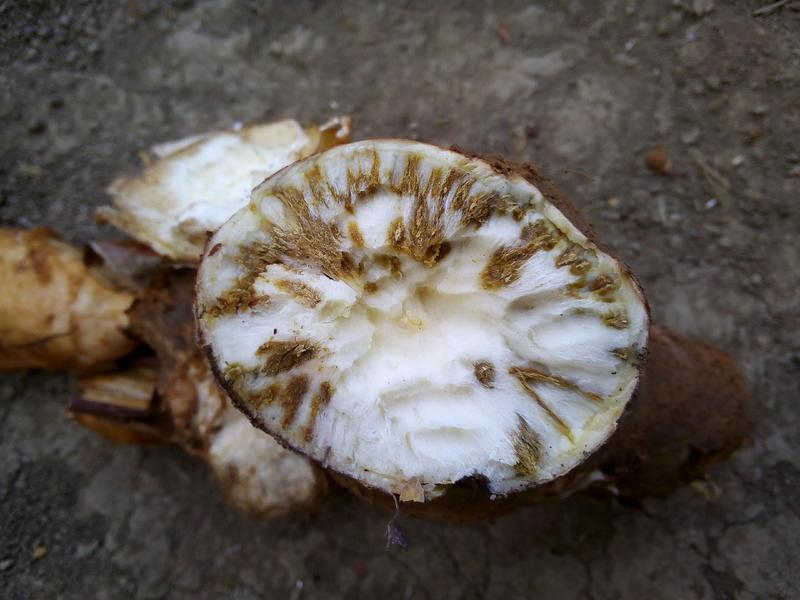

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


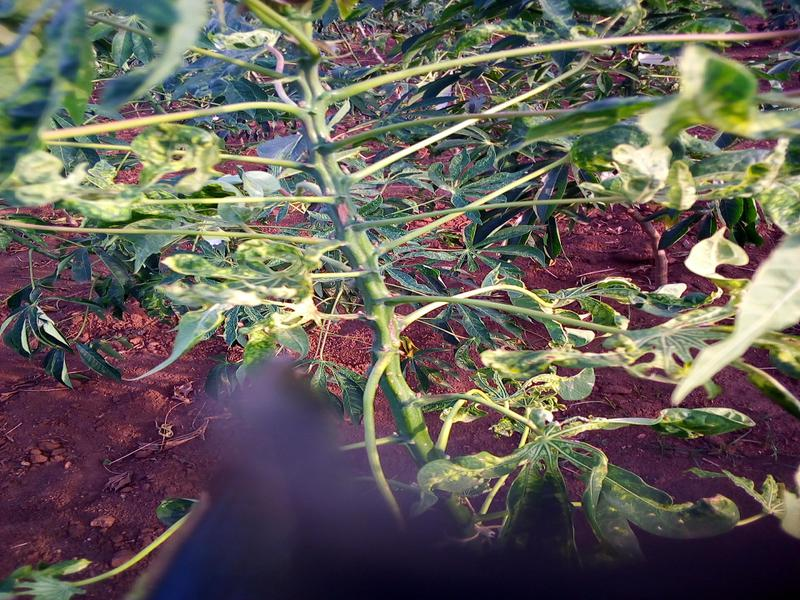

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


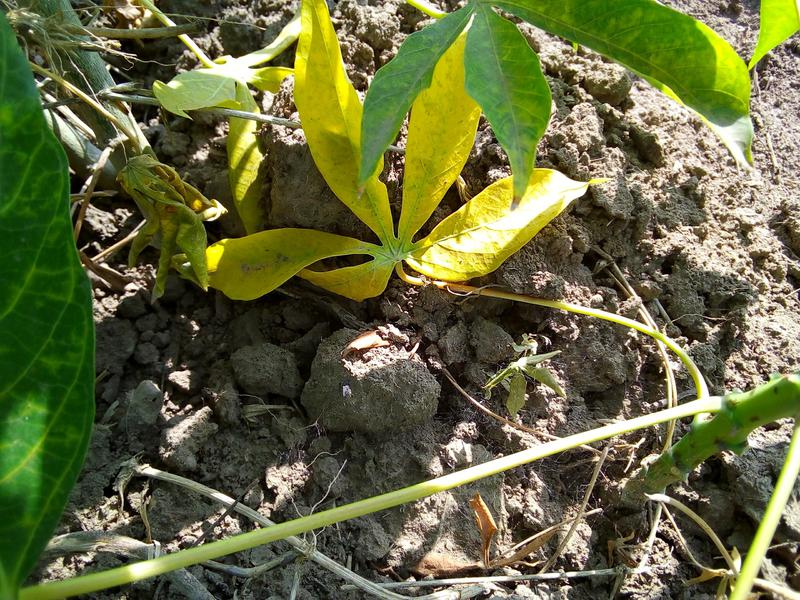

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


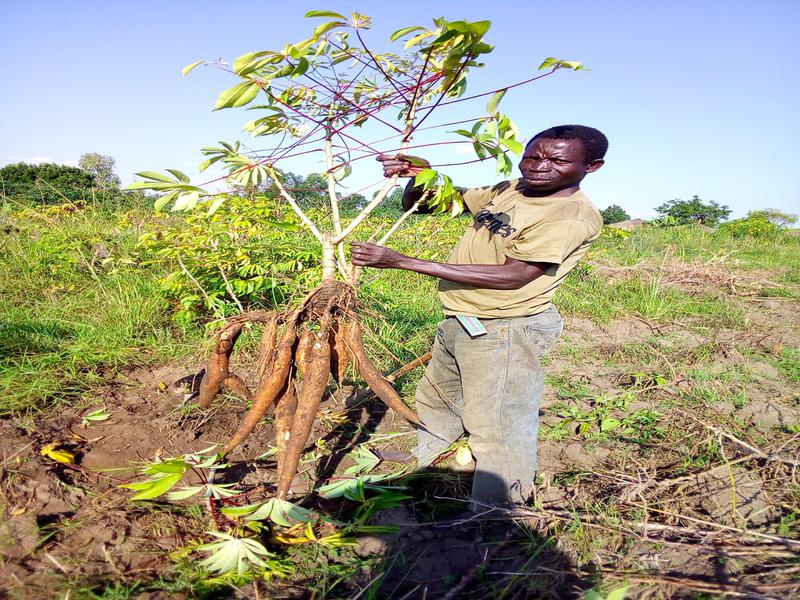

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


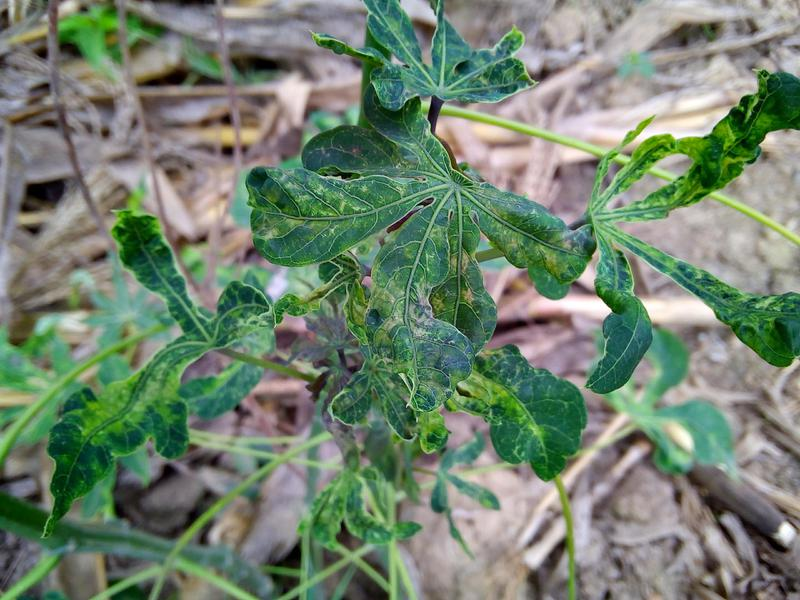

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


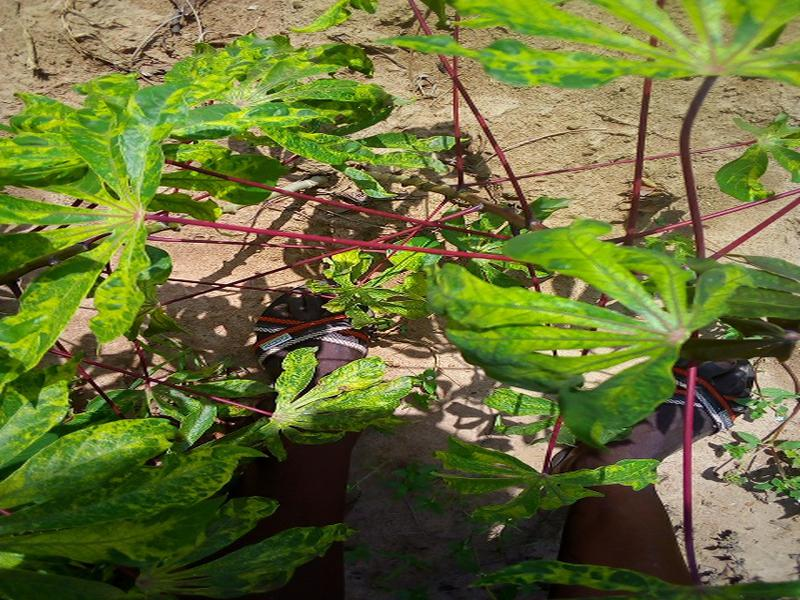

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


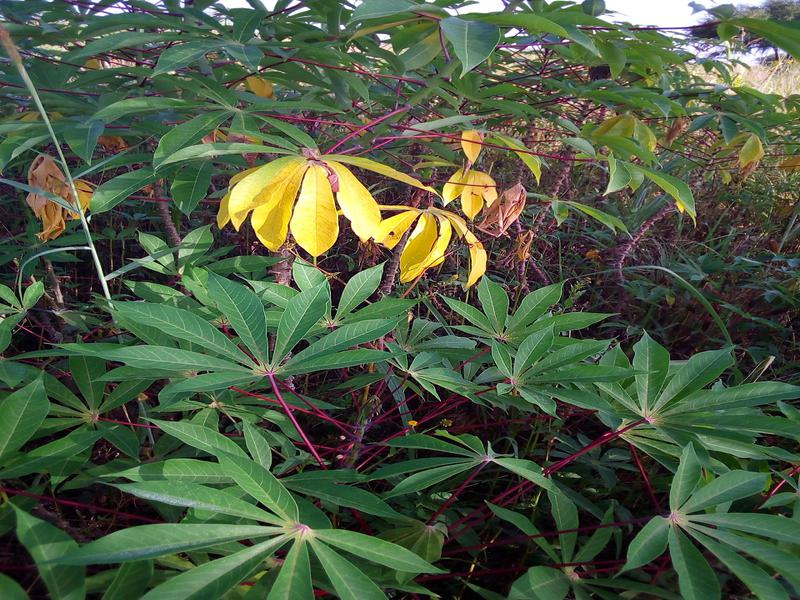

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


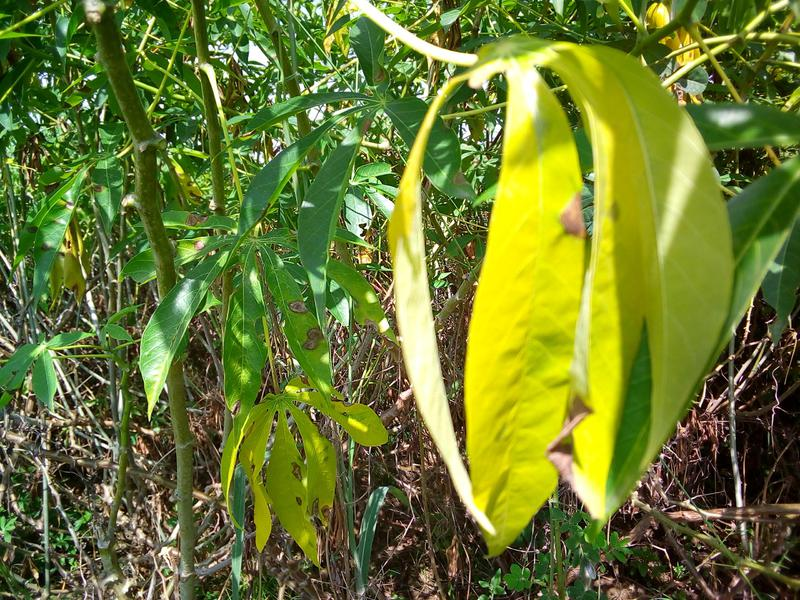

In [19]:
for index, row in svm_if_results[svm_if_results['oc_svm_preds']!=svm_if_results['is_cassava']].head(25).iterrows():
    if row['oc_svm_preds']==1:
        print('FALSE POSITIVE')
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_cassava']))
        display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_cassava']))
        display(Image(row['path']))

In [80]:
path_test = "C:\\Github\\Cassava-Disease-Classification-Using-Line-BOT\\Dataset\\natural_images\\cassava\\1109928772.jpg"
imgs = load_img(path_test, target_size=(image_size, image_size))
img_array = np.array(img_to_array(imgs))
    #output = img_array
output = preprocess_input(img_array)

In [87]:
# r = resnet_model.predict(output)
# r
output.shape
# Apply standard scaler to output from resnet50
output = ss.transform(output)
# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=512, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
output = pca.transform(output)
oc_svm_clf.fit(output)

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.